# NeurIPS2024 AI Trends Analysis: 

This notebook explores and visualizes trends in AI research presented at NeurIPS 2024.
It includes keyword analysis, word clouds, and topic frequency tracking across sessions and papers to uncover emerging areas of focus. 
Using advanced NLP techniques, the project categorizes AI methods and topics like transformers, diffusion models, reinforcement learning, and more highlighting their impact and evolution over time.

Key Features:
- Comprehensive analysis of NeurIPS 2024 keywords and research topics.
- Word cloud visualizations showcasing trends across key AI methods.
- Ontology-driven topic clustering for structured insights.
- Comparison of AI research focus over multiple years.
- Easily extensible for other AI conferences and datasets.

## Importing Required Libraries

In [1]:
from typing import Dict, List
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


## Section 1: Data Extraction

In [2]:
def extract_titles_from_noscript(url: str) -> List[str]:
    """
    Extract paper titles from the <noscript> tags on the NeurIPS conference website.
    
    Args:
        url (str): The URL of the NeurIPS conference webpage.
    
    Returns:
        List[str]: A list of extracted paper titles.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    noscript_tags = soup.find_all('noscript')
    titles = [noscript.get_text(strip=True) for noscript in noscript_tags]
    return titles

### Define URLs for NeurIPS years

#### Function to generate URLs for a specified year range

In [3]:
def generate_neurips_urls(start_year: int, end_year: int) -> Dict[str, str]:
    """
    Generate a dictionary of NeurIPS conference URLs for a specified year range.
    
    Args:
        start_year (int): The starting year of the range.
        end_year (int): The ending year of the range.
    
    Returns:
        Dict[str, str]: A dictionary where the keys are years as strings and the values are the corresponding NeurIPS conference URLs.
    """
    base_url = "https://neurips.cc/virtual/{}/papers.html"
    return {str(year): base_url.format(year) for year in range(start_year, end_year + 1)}

In [4]:
# Specify the year range
start_year = 2020
end_year = 2024

# Generate URLs for the specified range
urls = generate_neurips_urls(start_year, end_year)

print("Generated URLs:", urls)


Generated URLs: {'2020': 'https://neurips.cc/virtual/2020/papers.html', '2021': 'https://neurips.cc/virtual/2021/papers.html', '2022': 'https://neurips.cc/virtual/2022/papers.html', '2023': 'https://neurips.cc/virtual/2023/papers.html', '2024': 'https://neurips.cc/virtual/2024/papers.html'}


## Section 2: Extract Titles

In [5]:

def extract_titles_from_noscript(url: str) -> List[str]:
    """
    Extract paper titles from the <noscript> tags on the NeurIPS conference website.
    
    Args:
        url (str): The URL of the NeurIPS conference webpage.
    
    Returns:
        List[str]: A list of extracted paper titles.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        noscript_tags = soup.find_all('noscript')
        titles = [noscript.get_text(strip=True) for noscript in noscript_tags]
        return titles
    except requests.RequestException as e:
        print(f"Error fetching the page: {e}")
        return []

# Extract data for each year
all_titles: Dict[str, List[str]] = {year: extract_titles_from_noscript(url) for year, url in urls.items()}

# Combine all extracted titles into a single string per year
data: Dict[str, str] = {year: " ".join(titles) for year, titles in all_titles.items()}


## Section 3: Data Cleaning

In [6]:
def clean_text(raw_text: str) -> str:
    """
    Clean raw text by removing HTML tags, special characters, numbers, and normalizing spaces.
    
    Args:
        raw_text (str): Raw input text to be cleaned.
    
    Returns:
        str: Cleaned text.
    """
    text = re.sub(r"<.*?>", " ", raw_text)  # Remove HTML tags
    text = text.lower()  # Normalize to lowercase
    text = re.sub(r"[-:;.,!?*&^%$#@()+\n]", " ", text)  # Replace special characters with spaces
    text = re.sub(r"\b\d+\b", " ", text)  # Remove standalone numbers
    text = re.sub(r"[^\w\s]", " ", text)  # Remove any remaining special characters
    text = re.sub(r"\s+", " ", text).strip()  # Normalize spaces
    return text

# Clean all titles
cleaned_data: Dict[str, str] = {year: clean_text(data[year]) for year in data}


## Section 4: Keyword Frequency Analysis

### Define stop words: generic AI terms and common English words

In [16]:
ai_stop_words: set = {
    "ai", "ml", "machine learning", "artificial intelligence", "learning", "data", 
    "dataset", "datasets", "neural network", "network", "model", "models", "algorithm", 
    "algorithms", "training", "results", "performance", "task", "tasks", "multi", "based", "neural", "large","text"
}

generic_english_stop_words: set = {
    "a", "an", "the", "and", "or", "in", "on", "at", "of", "for", "about", "with", "to", 
    "from", "by", "this", "that", "is", "it", "as", "was", "were", "are", "be", "has", 
    "have", "had", "not", "but", "if", "then", "than", "so", "such", "all", "any", "some", 
    "no", "yes", "do", "does", "did", "will", "shall", "may", "can", "would", "could", "using",
    "should", "there", "here", "their", "these", "those", "my", "mine", "our", "ours", "via", "efficient", "time"
}

### Combine AI-specific and English stop words and text processing

In [17]:
stop_words: set = ai_stop_words.union(generic_english_stop_words)

In [18]:
def preprocess_text(text: str) -> str:
    """
    Normalize and prepare text for analysis by removing hyphens and converting to lowercase.
    
    Args:
        text (str): The text to preprocess.
    
    Returns:
        str: The preprocessed text.
    """
    text = text.lower()  # Normalize to lowercase
    text = re.sub(r"[-]", " ", text)  # Replace hyphens with spaces
    return text




### Count word frequencies

In [19]:
def count_word_frequencies(text: str) -> Counter:
    """
    Count the frequencies of words in the text, excluding specified stop words.
    
    Args:
        text (str): The text to analyze.
    
    Returns:
        Counter: A counter of word frequencies, excluding stop words.
    """
    text = preprocess_text(text)
    words = re.findall(r'\b\w+\b', text)  # Tokenize text into words
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    return Counter(filtered_words)

# Analyze trends for each year (excluding stop words)
def calculate_word_frequencies_per_year(cleaned_data: Dict[str, str]) -> Dict[str, Counter]:
    """
    Calculate word frequencies for each year.
    
    Args:
        cleaned_data (Dict[str, str]): Year-wise cleaned text data.
    
    Returns:
        Dict[str, Counter]: Year-wise word frequencies as a dictionary.
    """
    return {year: count_word_frequencies(text) for year, text in cleaned_data.items()}

# Calculate word frequencies
word_frequencies_per_year = calculate_word_frequencies_per_year(cleaned_data)


### Generate word clouds for each year using the preprocessed and cleaned data



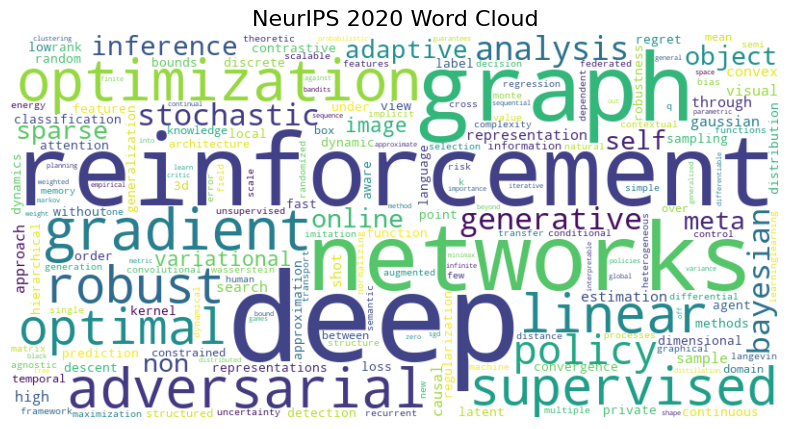

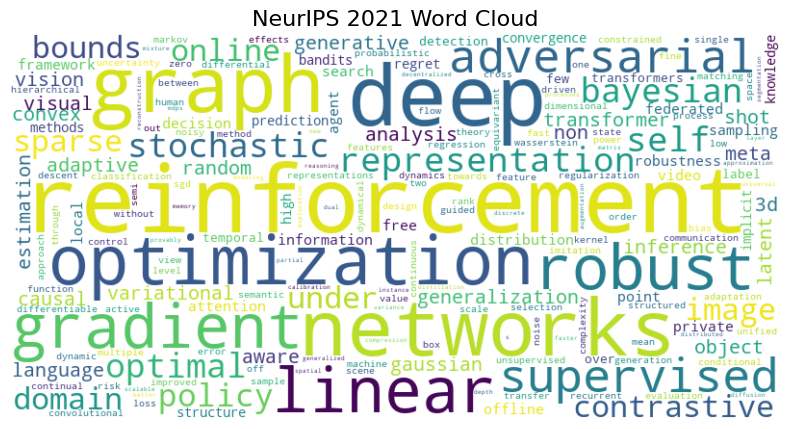

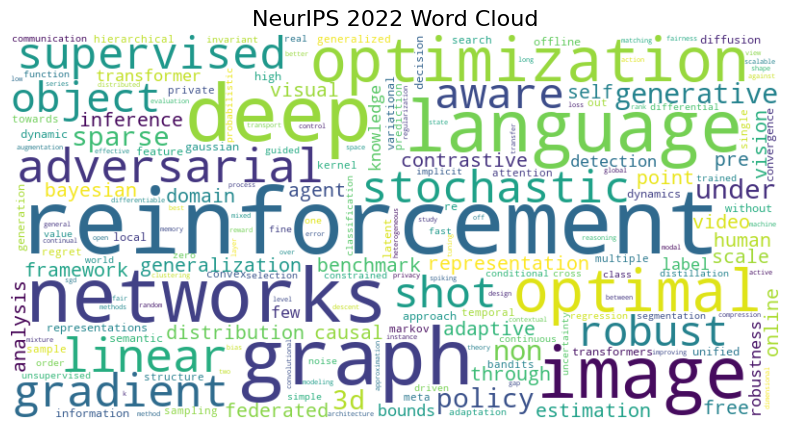

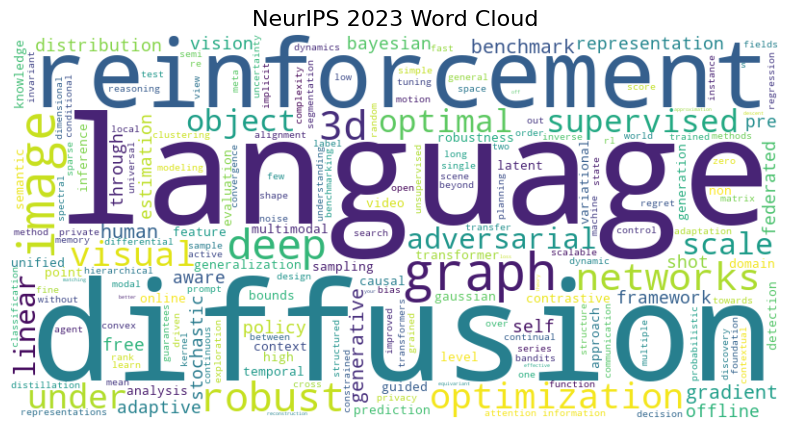

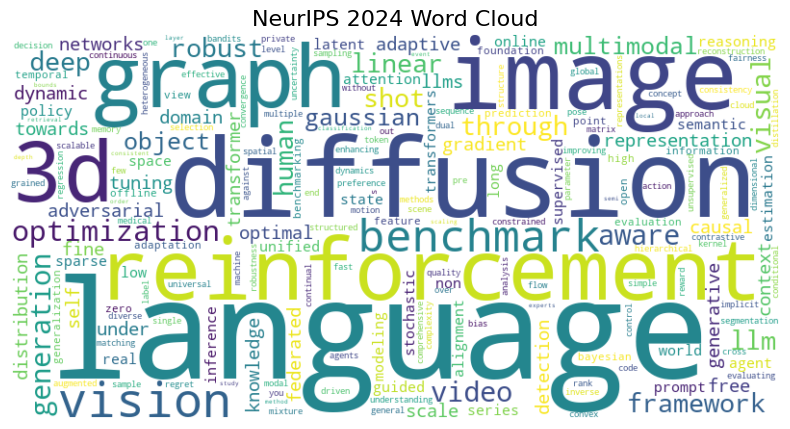

In [23]:
def generate_wordclouds_from_word_frequencies(frequencies: Dict[str, Counter]) -> None:
    """
    Generate and display word clouds for each year based on word frequencies.
    
    Args:
        frequencies (Dict[str, Counter]): A dictionary containing year-wise word frequencies.
    """
    for year, freqs in frequencies.items():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freqs)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"NeurIPS {year} Word Cloud", fontsize=16)
        plt.show()
        
generate_wordclouds_from_word_frequencies(word_frequencies_per_year)

## Section 5: Visualization of Trends

### Bar-plots

In [51]:
print(word_frequencies_per_year["2020"].most_common(10))

[('deep', 128), ('reinforcement', 90), ('graph', 82), ('networks', 82), ('optimization', 62), ('gradient', 61), ('adversarial', 57), ('linear', 56), ('supervised', 54), ('robust', 52)]


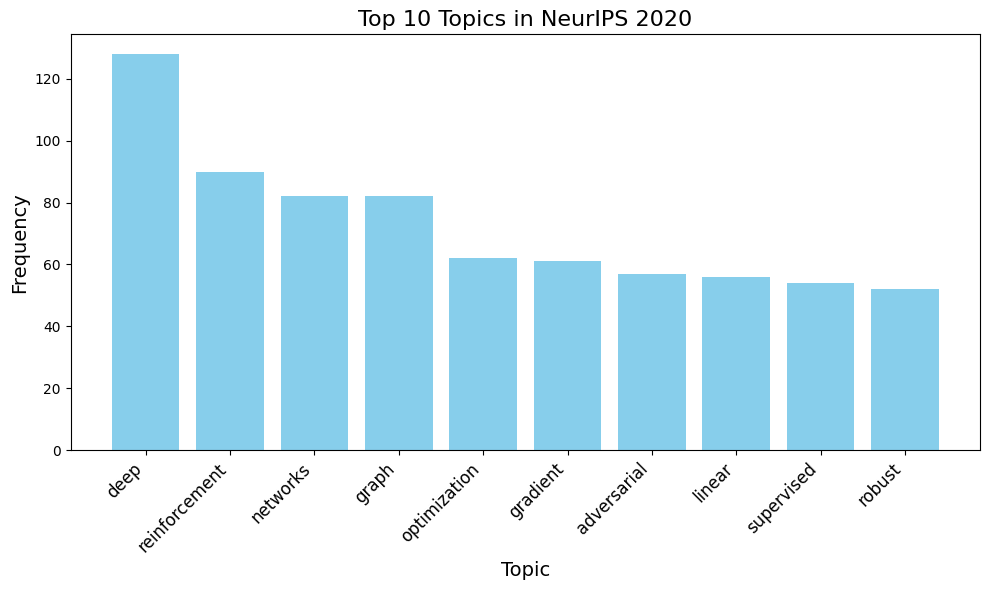

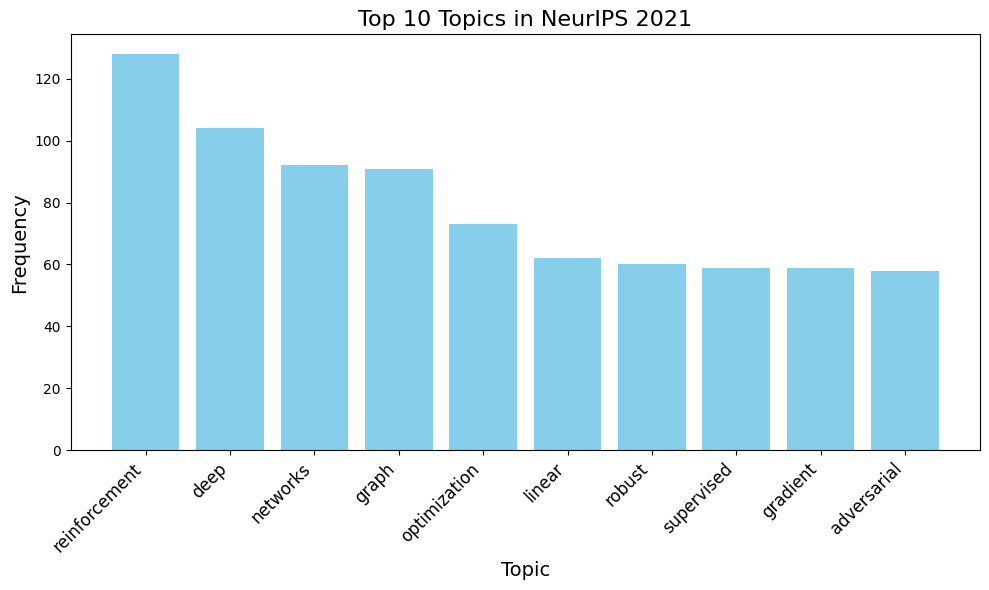

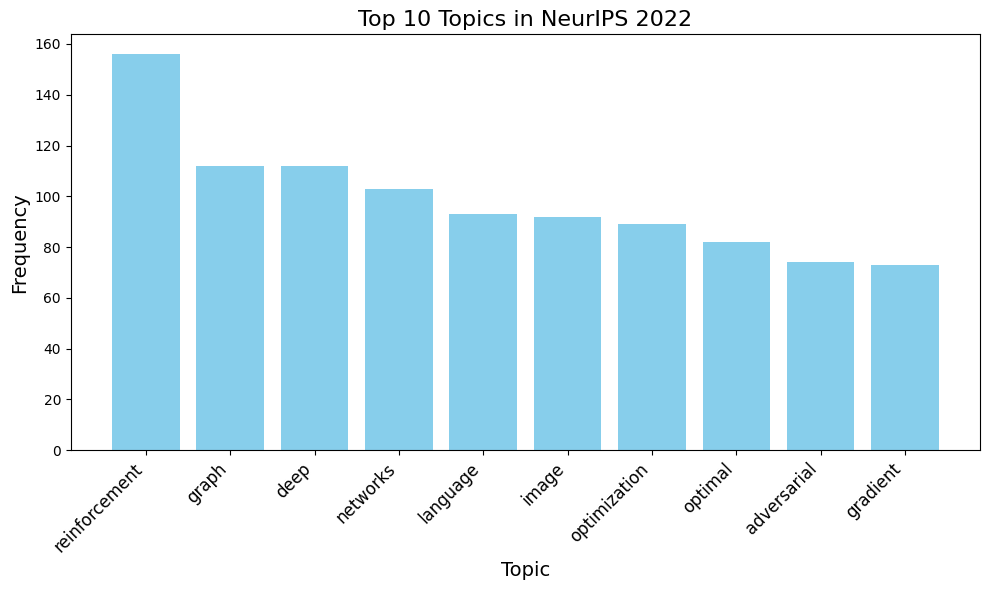

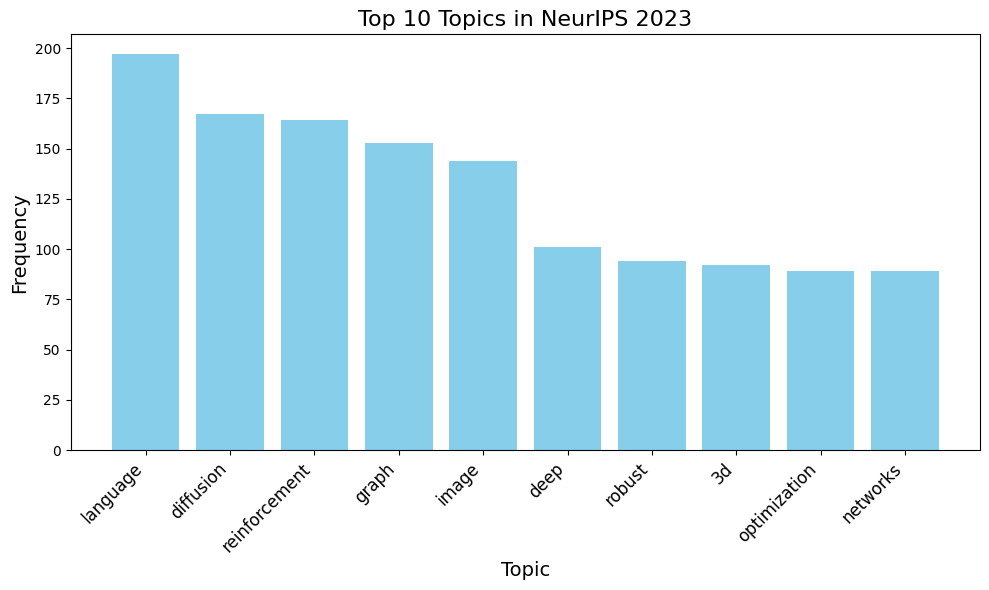

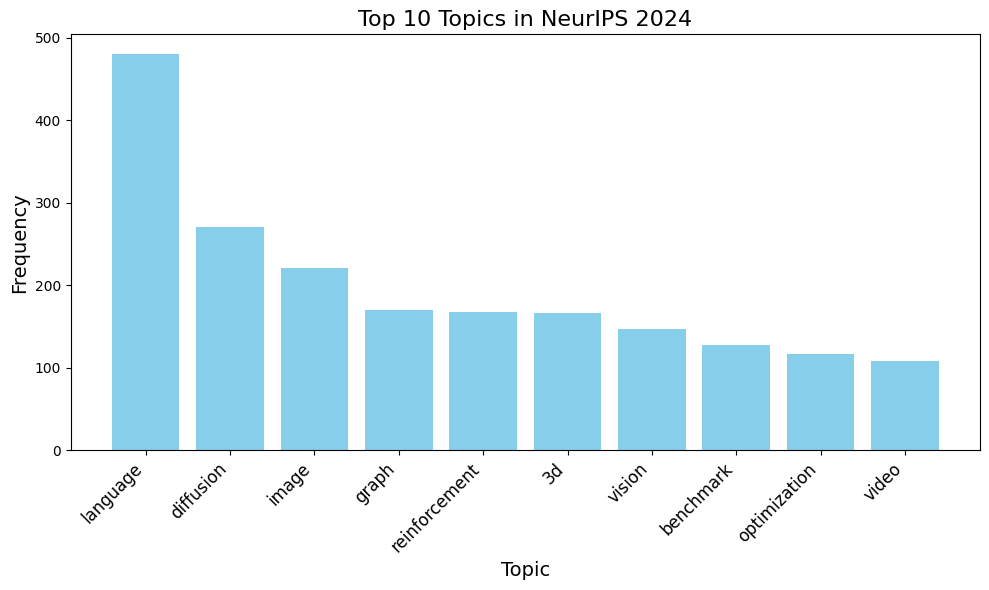

In [52]:
def plot_top_topics(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    """
    Generate bar plots to display the top N topics for each year.
    
    Args:
        word_frequencies_per_year (Dict[str, Counter]): Year-wise word frequencies as a dictionary.
        top_n (int): The number of top topics to display.
    """
    for year, frequencies in word_frequencies_per_year.items():
        # Convert the Counter object to a DataFrame
        df = pd.DataFrame(frequencies.items(), columns=["Topic", "Frequency"])
        # Sort by frequency and select the top N topics
        top_topics = df.sort_values(by="Frequency", ascending=False).head(top_n)
        
        # Plot the bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(top_topics["Topic"], top_topics["Frequency"], color="skyblue")
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.title(f"Top {top_n} Topics in NeurIPS {year}", fontsize=16)
        plt.xlabel("Topic", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.tight_layout()
        plt.show()

# Plot the top 10 topics for each year
plot_top_topics(word_frequencies_per_year, top_n=10)

### Trend changes

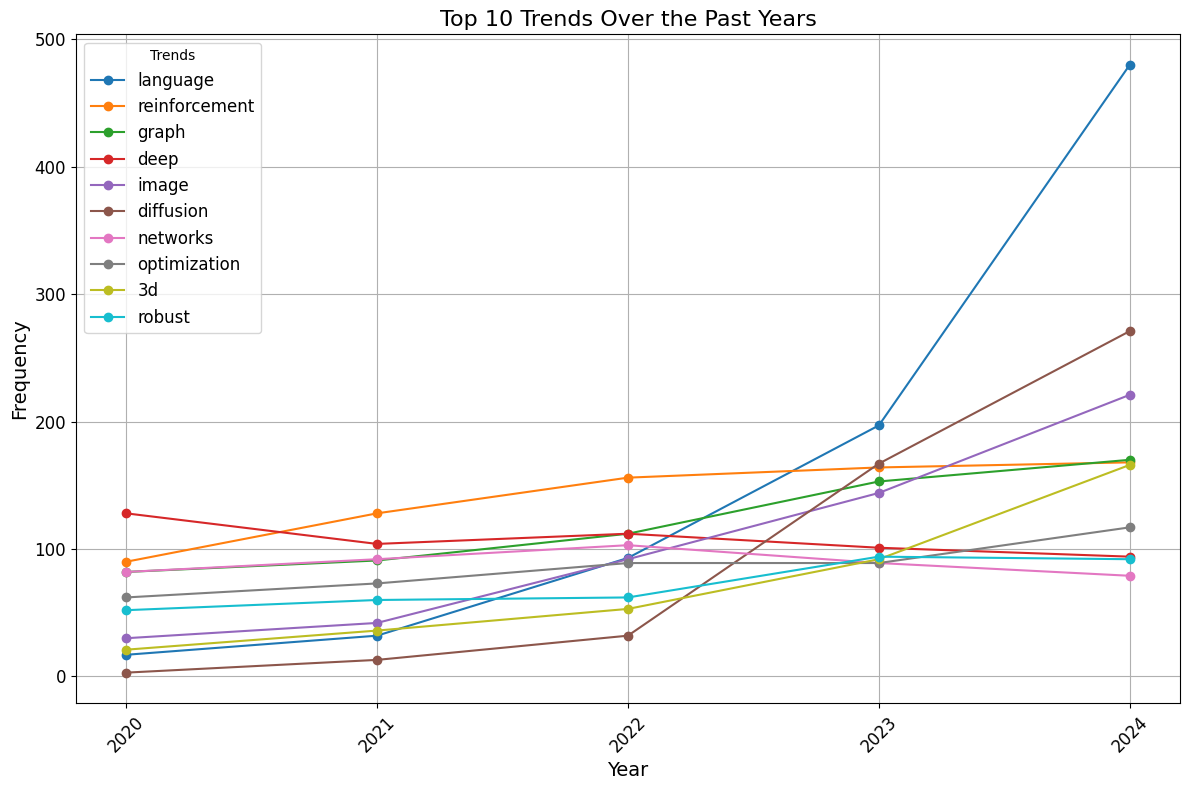

In [53]:
def plot_trend_changes(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    """
    Plot how the top trends have changed over the past years in a line plot.
    
    Args:
        word_frequencies_per_year (Dict[str, Counter]): Year-wise word frequencies as a dictionary.
        top_n (int): The number of top topics to track over the years.
    """
    # Combine all word frequencies into a DataFrame
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    
    # Get the top N trends by overall frequency
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    
    # Filter DataFrame to include only the top trends
    trends_df = trends_df.loc[top_trends]
    
    # Transpose the DataFrame for plotting
    trends_df = trends_df.transpose()
    
    # Plot the trends
    plt.figure(figsize=(12, 8))
    for trend in top_trends:
        plt.plot(trends_df.index, trends_df[trend], marker="o", label=trend)
    
    plt.title(f"Top {top_n} Trends Over the Past Years", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(trends_df.index, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Trends", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the trends
plot_trend_changes(word_frequencies_per_year, top_n=10)


### Atacked area trends

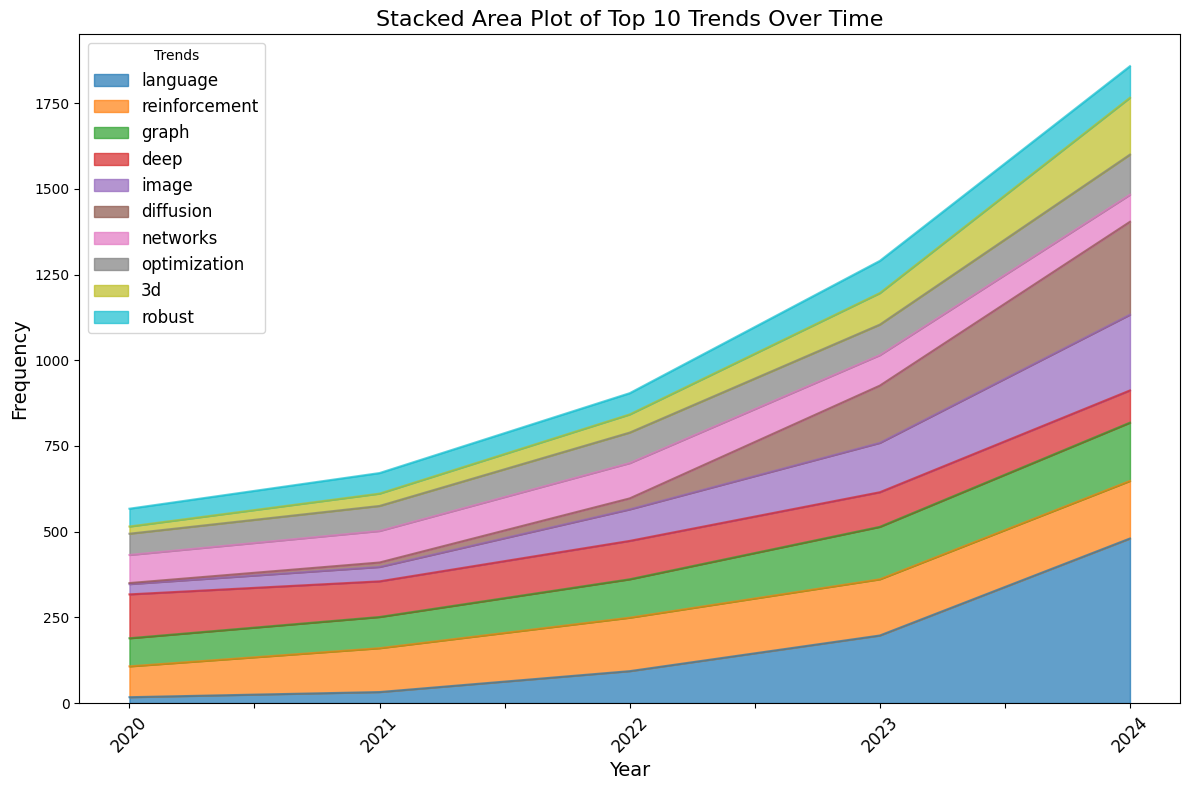

In [54]:
def plot_stacked_area_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    trends_df_normalized = trends_df.div(trends_df.sum(axis=1), axis=0)  # Normalize for proportional comparison

    trends_df.plot.area(figsize=(12, 8), alpha=0.7)
    plt.title(f"Stacked Area Plot of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title="Trends", fontsize=12, loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot Stacked Area Plot for top 10 trends
plot_stacked_area_trends(word_frequencies_per_year, top_n=10)


### Heatmap trends

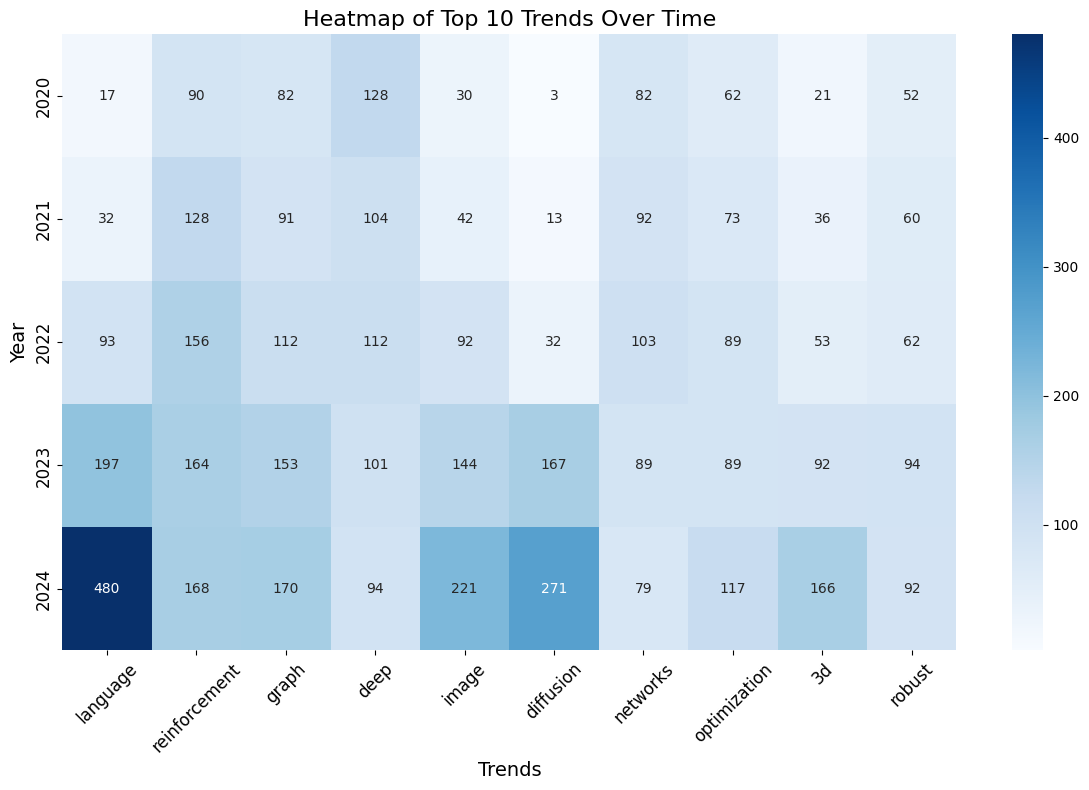

In [55]:
def plot_heatmap_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()

    plt.figure(figsize=(12, 8))
    sns.heatmap(trends_df, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title(f"Heatmap of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Trends", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot Heatmap for top 10 trends
plot_heatmap_trends(word_frequencies_per_year, top_n=10)

### Bubble trends

In [56]:
def plot_bubble_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    trends_df = trends_df.reset_index().melt(id_vars="index", var_name="Trend", value_name="Frequency")

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=trends_df,
        x="index",
        y="Trend",
        size="Frequency",
        sizes=(50, 500),
        hue="Trend",
        palette="tab10",
        legend=False
    )
    plt.title(f"Bubble Chart of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Trends", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()


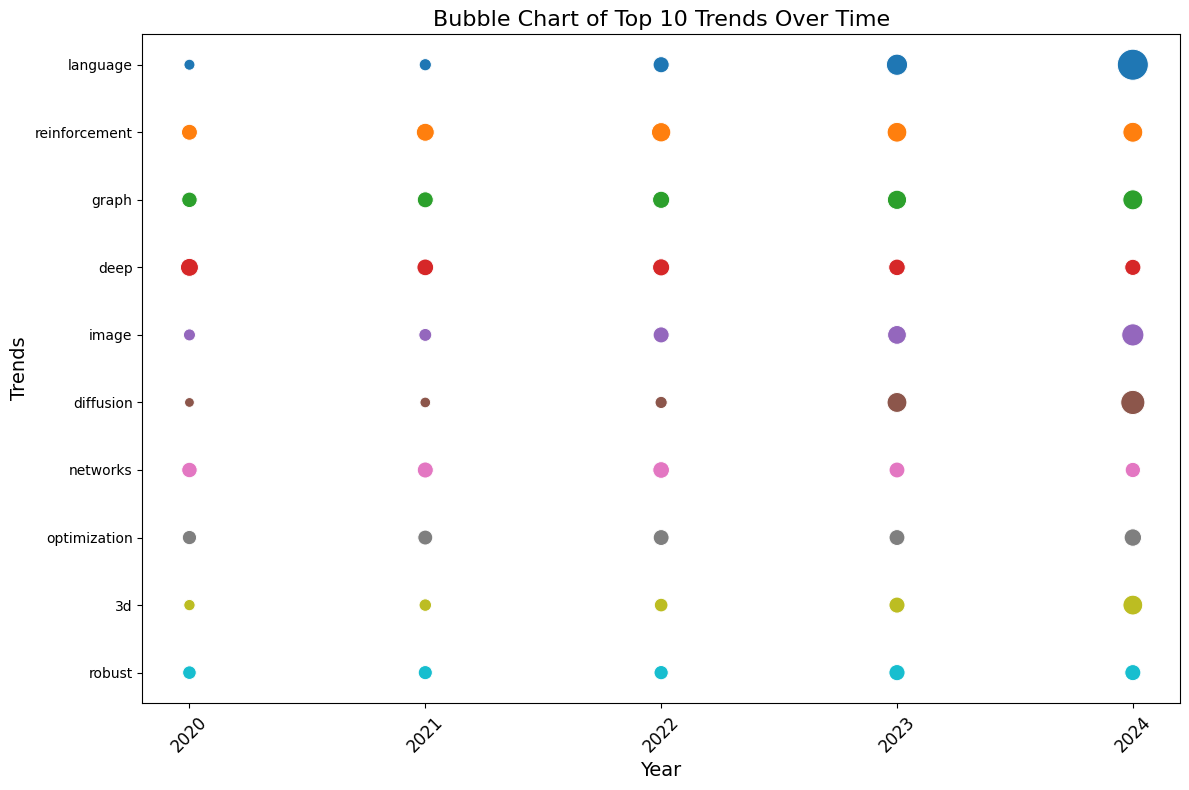

In [57]:
# Plot Bubble Chart for top 10 trends
plot_bubble_trends(word_frequencies_per_year, top_n=10)

### Small multiples trends

In [58]:

def plot_small_multiples_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int = 10) -> None:
    """
    Plot small multiples trends for the top N topics over years with enhanced aesthetics and unique colors.

    Args:
        word_frequencies_per_year (Dict[str, Counter]): A dictionary of word frequencies per year.
        top_n (int): Number of top topics to visualize.

    Returns:
        None
    """
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()

    # Determine layout (two columns)
    n_rows = (top_n + 1) // 2  # Rows needed for two columns
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows), sharex=True, sharey=True)

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Generate a color palette
    color_palette = plt.cm.tab10.colors  # Tab10 has distinct colors
    num_colors = len(color_palette)

    # Plot each trend with unique color
    for idx, (ax, trend) in enumerate(zip(axes, top_trends)):
        color = color_palette[idx % num_colors]  # Cycle through the color palette
        trends_df[trend].plot(ax=ax, marker="o", color=color, legend=False)
        ax.set_title(trend, fontsize=14)
        ax.legend([trend], loc="upper left", fontsize=14)
        ax.grid(True)
        if idx >= len(top_trends):  # Hide unused axes
            ax.axis("off")

    # General settings
    for ax in axes[-2:]:  # Last row for shared X-axis label
        ax.set_xlabel("Year", fontsize=16)

    fig.suptitle(f"Small Multiples of Top {top_n} Trends Over Time", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

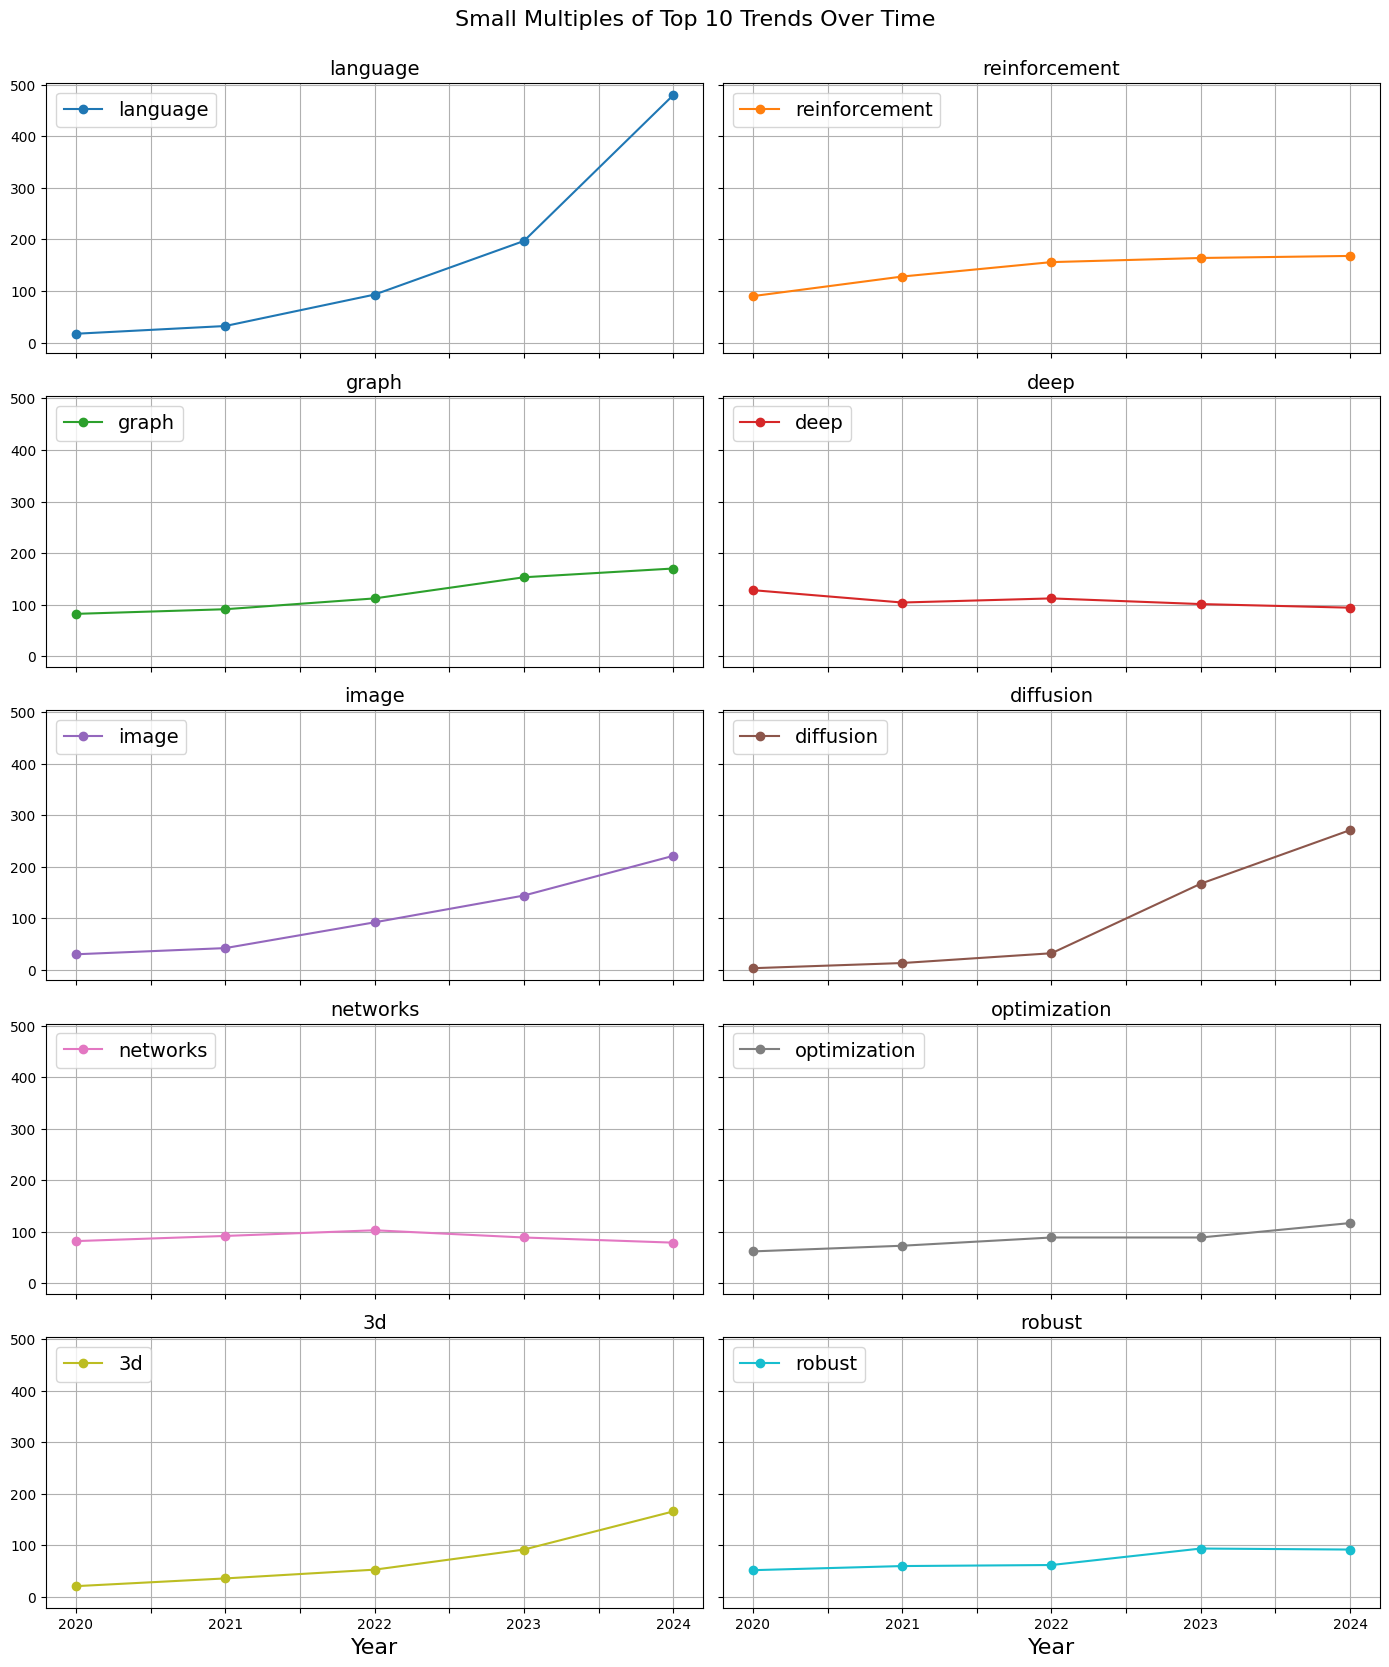

In [59]:
# Plot Small Multiples Line Plots for top 10 trends
plot_small_multiples_trends(word_frequencies_per_year, top_n=10)


## Section 6: Ontology-Based Keyword Analysis

### Defining ontology dictionary

In [60]:
method_keywords = {
    # Generative Models
    "Diffusion": [
        "diffusion models", "diffusion", "diffusivity", "diffuse", "denoising diffusion", 
        "stable diffusion", "flow models", "score-based diffusion", "latent diffusion"
    ],
    "GANs": [
        "gan", "generative adversarial networks", "adversarial training", "cycle-gan", 
        "stylegan", "progressive gan", "biggan", "wasserstein gan", "dcgan"
    ],
    "VAEs": [
        "vae", "variational autoencoders", "variational inference", 
        "hierarchical vae", "conditional vae", "semi-supervised vae"
    ],
    "Autoregressive": [
        "autoregressive models", "autoregressive", "seq2seq", "auto-regressive", 
        "masked autoencoder", "transformer-decoder"
    ],

    # Transformers and Related Models
    "Transformers": [
        "transformers", "bert", "gpt", "attention", "self-attention", 
        "multi-head attention", "roberta", "encoder-decoder", "attention mechanism", 
        "transformer architecture", "transformer models"
    ],
    "Foundation Models": [
        "foundation models", "large-scale pretrained models", "scalable models", 
        "t5", "unified models", "llm", "large language models", "foundation", 
        "language foundation models", "pretrained large models"
    ],

    # Pretraining and Fine-tuning
    "Pretraining": [
        "pretraining", "pre-trained models", "unsupervised pretraining", 
        "masked pretraining", "language model pretraining", "self-supervised pretraining"
    ],
    "Fine-Tuning": [
        "fine-tuning", "finetuning", "fine-tune", "task-specific fine-tuning", 
        "hyperparameter tuning", "transfer learning fine-tuning"
    ],

    # Vision, Image, and Video Processing
    "Vision": [
        "vision", "computer vision", "vision tasks", "vision models", "3d vision", 
        "spatial vision", "image", "images", "imaging", "image processing", 
        "image segmentation", "image detection", "object detection", 
        "image classification", "image reconstruction", "instance segmentation", 
        "semantic segmentation"
    ],
    "Video": [
        "video", "video processing", "video segmentation", "video detection", 
        "video understanding", "temporal video analysis", "video classification"
    ],

    # Multi-Modal Learning
    "Multi-Modal": [
        "multi-modal", "multi-modal learning", "multi-modal fusion", 
        "multi-modal representation", "cross-modal learning", "image-video fusion", 
        "audio-visual models", "cross-modal embeddings", "multimodal"
    ],

    # Graph Methods
    "GNNs": [
        "graph neural networks", "gnn", "graph convolutional networks", 
        "graph embeddings", "message passing", "heterogeneous graphs", 
        "gcnn", "gcnns", "gnns", "graph attention networks", 
        "sequential graph", "node embeddings", "spatio-temporal graphs"
    ],
    "Graphs": [
        "knowledge graphs", "semantic graphs", "knowledge embeddings", 
        "graph reasoning", "triplets", "graph", "graphs", "graph mining", 
        "DAG", "dynamic graph networks", "graph representations"
    ],
    "Causal": [
        "causal graphs", "causal discovery", "causal relationships", 
        "intervention graphs", "causal modeling", "causality", "causal", 
        "causal inference", "causal models", "causal reasoning", 
        "causal representation", "causal relationships"
    ],

    # Language Models
    "LLMs": [
        "llm", "large language models", "language models", "foundation models", 
        "causal language models", "autoregressive language models", 
        "language embeddings", "text models"
    ],
    "VLMs": [
        "vlm", "vision-language models", "vision language fusion", 
        "vision-language integration", "image-text models", 
        "text-to-image models", "image-to-text models"
    ],

    # Bayesian and Causal Inference
    "Bayesian Methods": [
        "bayesian", "bo", "probabilistic", "uncertainty", "posterior", 
        "prior", "monte carlo", "markov", "mcmc", "bayesian inference", 
        "variational bayes", "bayesian optimization", "gp", "gpr", "gps", 
        "gaussian processes", "bayesian neural networks"
    ],
    "Counterfactual Reasoning": [
        "counterfactuals", "counterfactual reasoning", "what-if analysis", 
        "counterfactual learning", "counterfactual examples"
    ],

    # Ontology and Semantic Models
    "Ontology": [
        "ontology", "semantic web", "semantic reasoning", "ontological models", 
        "knowledge representation", "ontology graphs", "ontological", 
        "semantic ontologies"
    ],

    # Optimization
    "Optimization": [
        "bo", "optimization", "bayesian optimization", "gradient descent", 
        "adam optimizer", "convex optimization", "non-convex optimization", 
        "stochastic optimization", "learning rates", "sgd", "rmsprop", 
        "adaptive optimization"
    ],

    # Reinforcement Learning
    "Reinforcement Learning": [
        "reinforcement learning", "policy gradient", "actor-critic", 
        "q-learning", "rewards", "value iteration", "ppo", "td learning", 
        "rl", "hfrl", "state-action space", "reinforcement agents"
    ],
    "Hierarchical RL": [
        "hierarchical reinforcement learning", "multi-agent rl", 
        "task decomposition", "cooperative rl", "collaborative agents"
    ],

    # Contrastive Learning and Representation Learning
    "Contrastive": [
        "contrastive learning", "contrastive loss", "self-supervised learning", 
        "contrastive representation", "negative sampling"
    ],
    "Representation": [
        "representation learning", "representation", "latent space", 
        "feature embeddings", "unsupervised representations", 
        "representation disentanglement", "semantic representations", 
        "representation learning methods"
    ],

    # Prompt Engineering and Zero-shot Learning
    "Prompting": [
        "prompt engineering", "prompt design", "prompt-based learning", 
        "instruction tuning", "prompt tuning"
    ],
    "Zero-shot": [
        "zero-shot learning", "zero-shot", "few-shot learning", 
        "few-shot", "in-context learning", "zero-shot transfer"
    ],

    # Applications of AI/ML
    "AI4Mat": [
        "materials informatics", "materials discovery", "materials design", 
        "inverse design", "materials optimization", "computational materials", 
        "molecular dynamics", "density functional theory", "spectroscopy analysis"
    ],
    "AI4Chem": [
        "computational chemistry", "molecular modeling", "reaction optimization", 
        "cheminformatics", "chemical informatics", "bioinformatics", 
        "drug discovery", "reaction pathways", "quantum simulations"
    ],
    "AI4Phys": [
        "computational physics", "quantum mechanics", "statistical mechanics", 
        "astrophysics", "fluid dynamics", "quantum field theory", 
        "molecular dynamics", "thermodynamics", "quantum entanglement"
    ]
}


### Ontology-Based Keyword Frequency Analysis

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict, List

# Function to count occurrences for ontology categories
def count_ontology_frequencies(
    text: str, 
    ontology: Dict[str, List[str]]
) -> Counter:
    """
    Count occurrences of ontology-defined keywords in text.

    Args:
        text (str): Preprocessed text to analyze.
        ontology (Dict[str, List[str]]): Ontology dictionary with categories and keywords.

    Returns:
        Counter: A dictionary of category frequencies.
    """
    text = text.lower()
    counts = Counter()
    for category, keywords in ontology.items():
        for keyword in keywords:
            matches = re.findall(rf"\b{re.escape(keyword)}\b", text)
            counts[category] += len(matches)
    return counts

# Perform ontology-based analysis for each year
ontology_frequencies_per_year = {}
for year, text in cleaned_data.items():
    ontology_frequencies_per_year[year] = count_ontology_frequencies(text, method_keywords)

# Convert ontology data to a DataFrame
ontology_df = pd.DataFrame(ontology_frequencies_per_year).fillna(0)

# Normalize for easier comparison
ontology_df_normalized = ontology_df.div(ontology_df.sum(axis=0), axis=1)

# Plot ontology analysis results
def plot_ontology_analysis(
    ontology_df: pd.DataFrame, 
    normalized: bool = False, 
    top_n: int = 10
) -> None:
    """
    Plot ontology-based trends across years.

    Args:
        ontology_df (pd.DataFrame): DataFrame with ontology-based counts per year.
        normalized (bool): Whether to normalize the data for comparison.
        top_n (int): Number of top categories to display.
    """
    data_to_plot = ontology_df
    if normalized:
        data_to_plot = ontology_df.div(ontology_df.sum(axis=0), axis=1)
    
    # Select top N categories by overall count
    top_categories = data_to_plot.sum(axis=1).sort_values(ascending=False).head(top_n).index
    data_to_plot = data_to_plot.loc[top_categories]

    # Plot trends for selected categories
    plt.figure(figsize=(12, 8))
    for category in top_categories:
        plt.plot(
            data_to_plot.columns, 
            data_to_plot.loc[category], 
            marker='o', 
            label=category
        )
    plt.title(f"Ontology-Based Trends ({'Normalized' if normalized else 'Raw'})", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency" if not normalized else "Proportion", fontsize=14)
    plt.legend(title="Categories", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Ontological trends

In [62]:
ontology_frequencies_per_year["2020"]

Counter({'Optimization': 103,
         'Bayesian Methods': 97,
         'Graphs': 89,
         'Reinforcement Learning': 63,
         'Vision': 48,
         'Representation': 39,
         'Transformers': 30,
         'Causal': 30,
         'GANs': 19,
         'GNNs': 13,
         'Contrastive': 10,
         'VAEs': 9,
         'Video': 9,
         'Multi-Modal': 5,
         'Diffusion': 4,
         'LLMs': 2,
         'Counterfactual Reasoning': 2,
         'AI4Phys': 1,
         'Autoregressive': 0,
         'Foundation Models': 0,
         'Pretraining': 0,
         'Fine-Tuning': 0,
         'VLMs': 0,
         'Ontology': 0,
         'Hierarchical RL': 0,
         'Prompting': 0,
         'Zero-shot': 0,
         'AI4Mat': 0,
         'AI4Chem': 0})

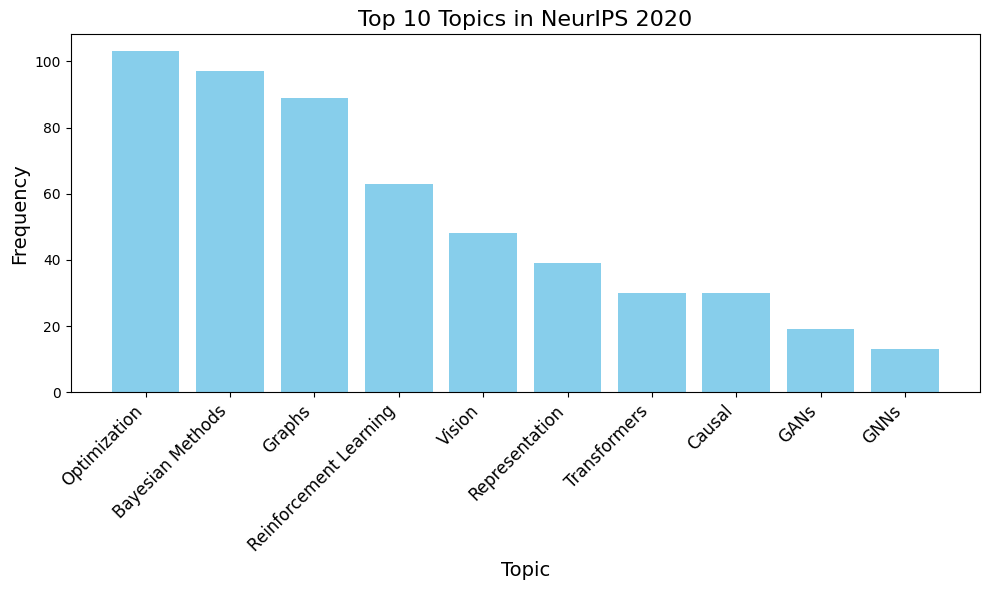

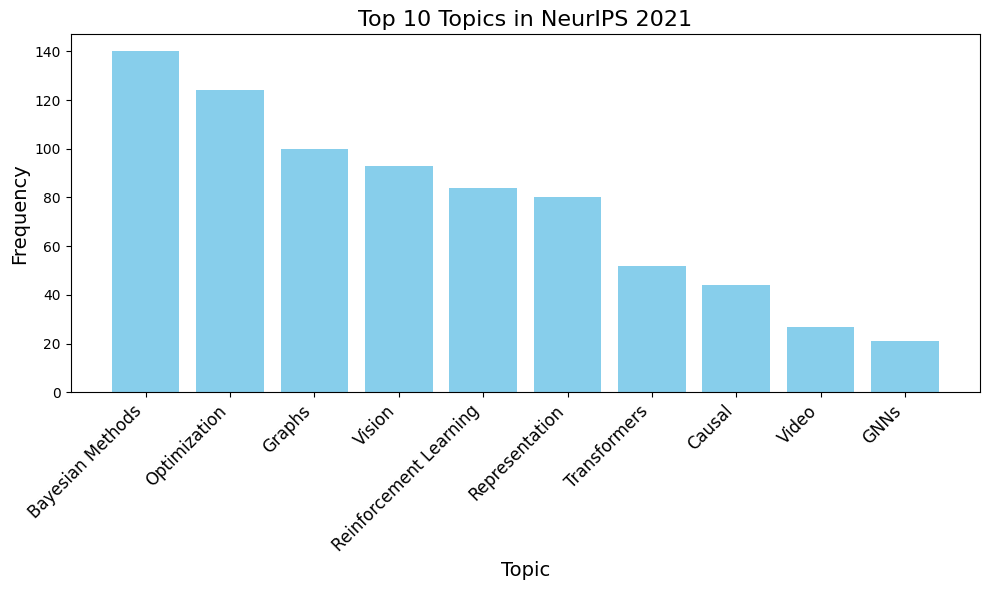

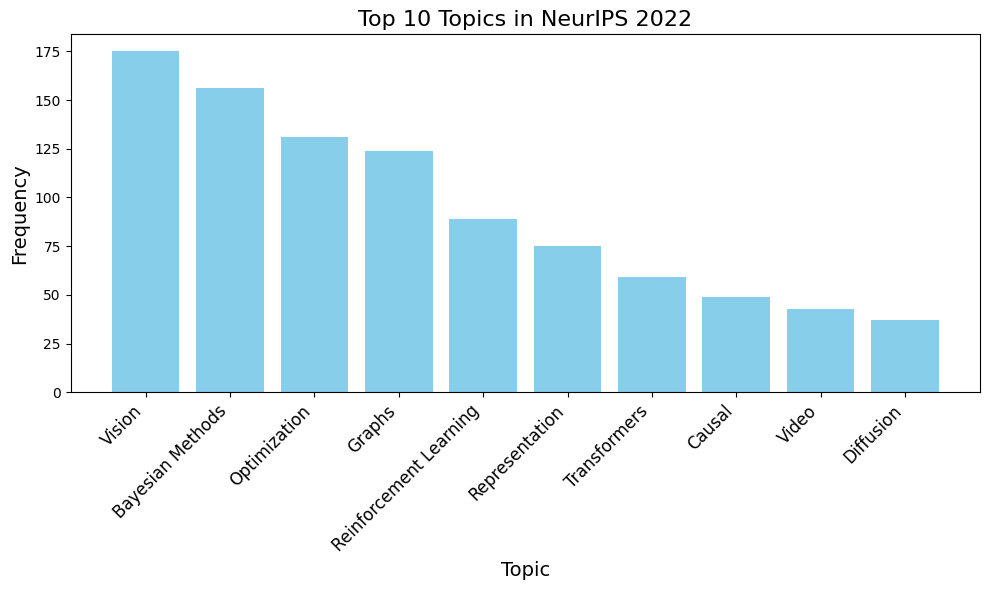

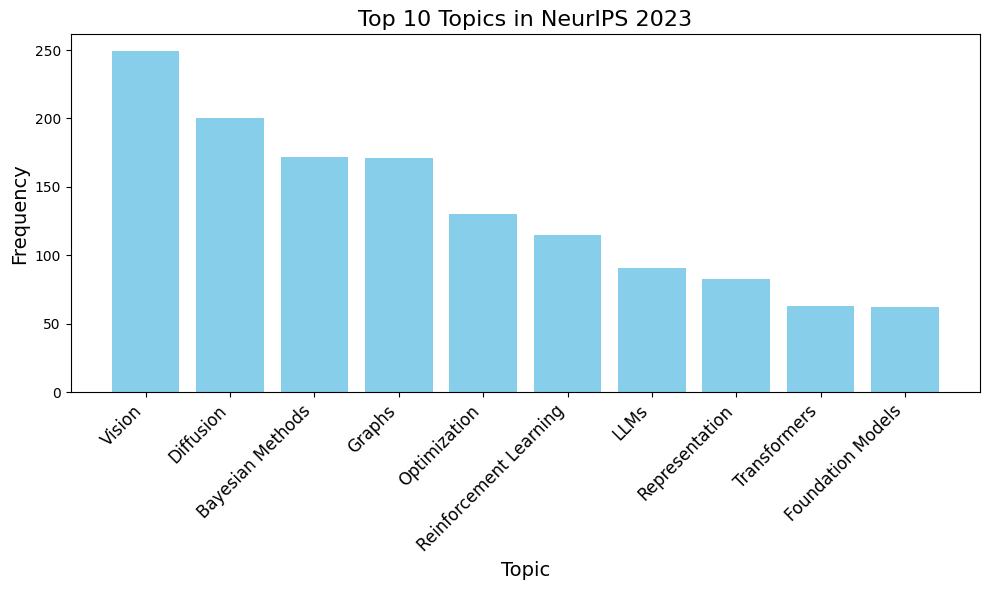

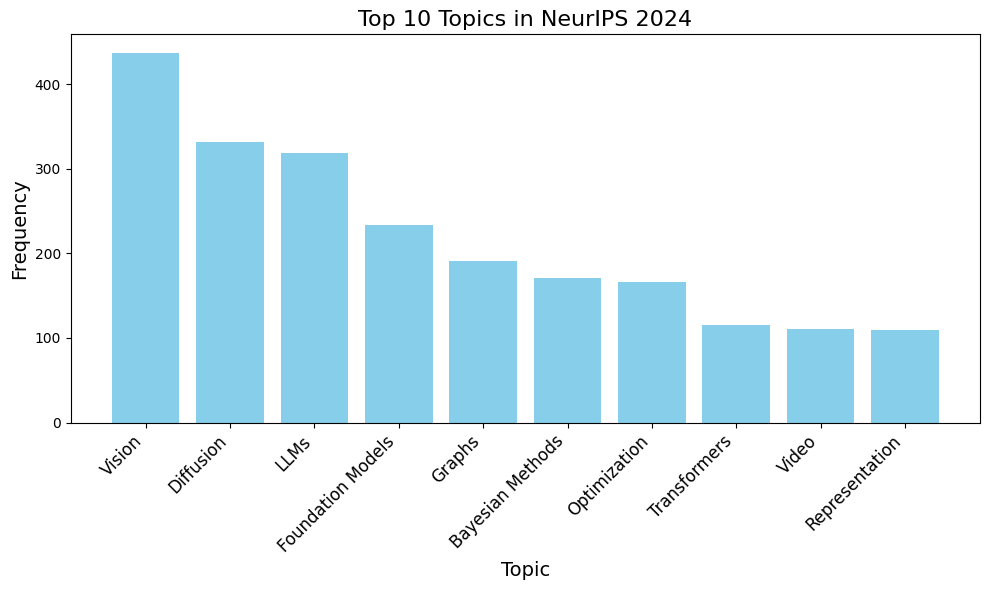

In [63]:
# Call the function to generate bar plots
plot_top_topics(ontology_frequencies_per_year, top_n=10)

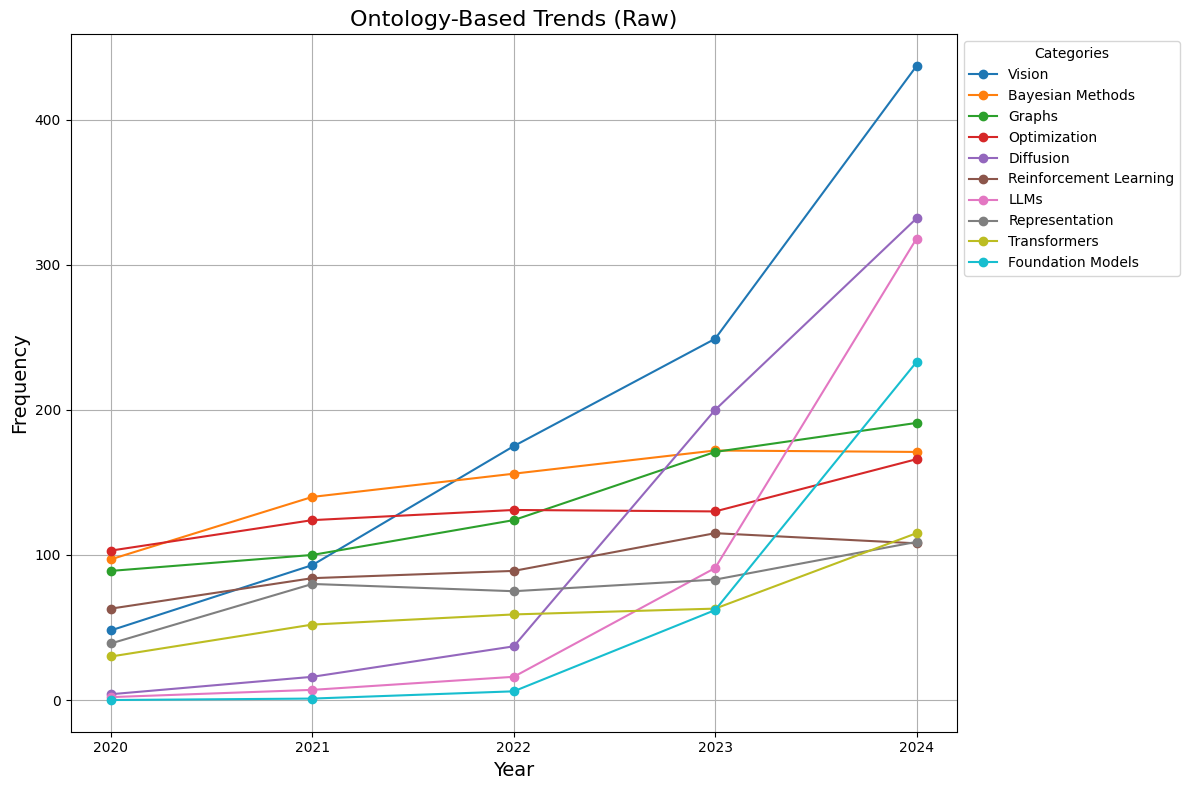

In [64]:
# Plot raw frequencies
plot_ontology_analysis(ontology_df, normalized=False, top_n=10)

### Normalized Ontological trends

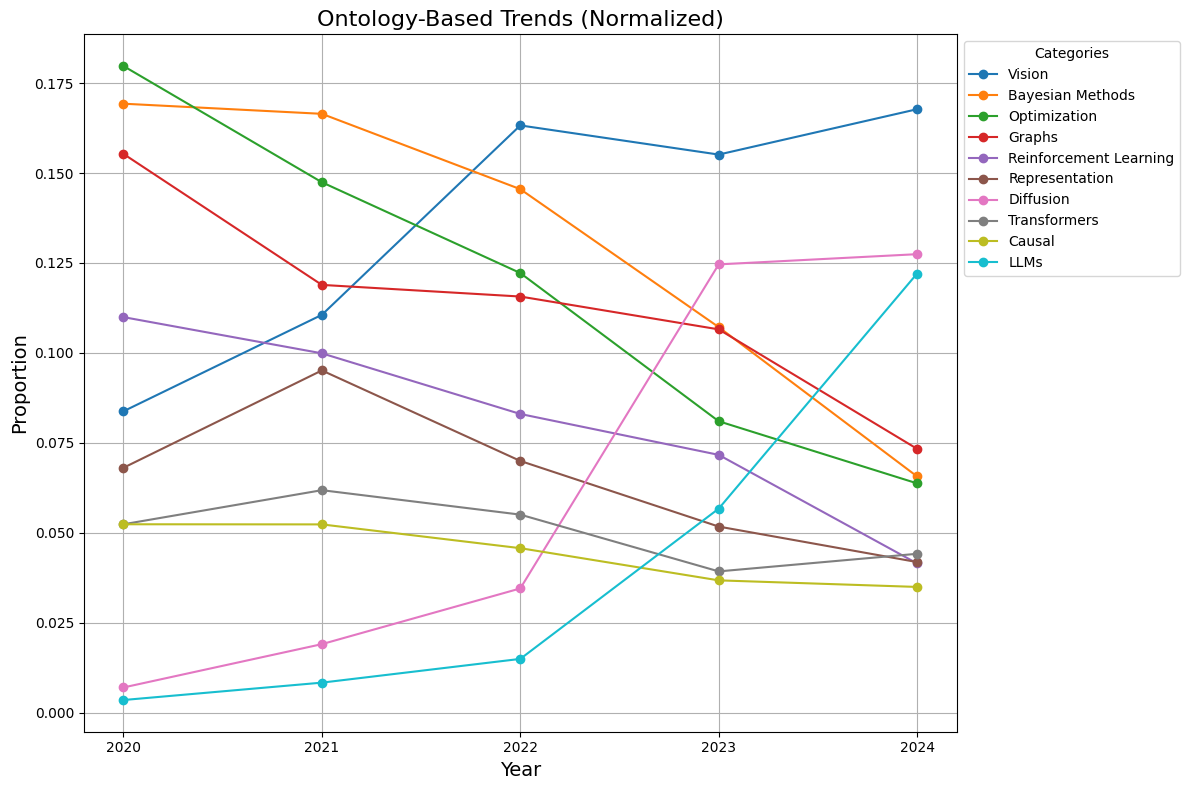

In [65]:
# Plot normalized frequencies
plot_ontology_analysis(ontology_df, normalized=True, top_n=10)


### Oncological heatmap trends

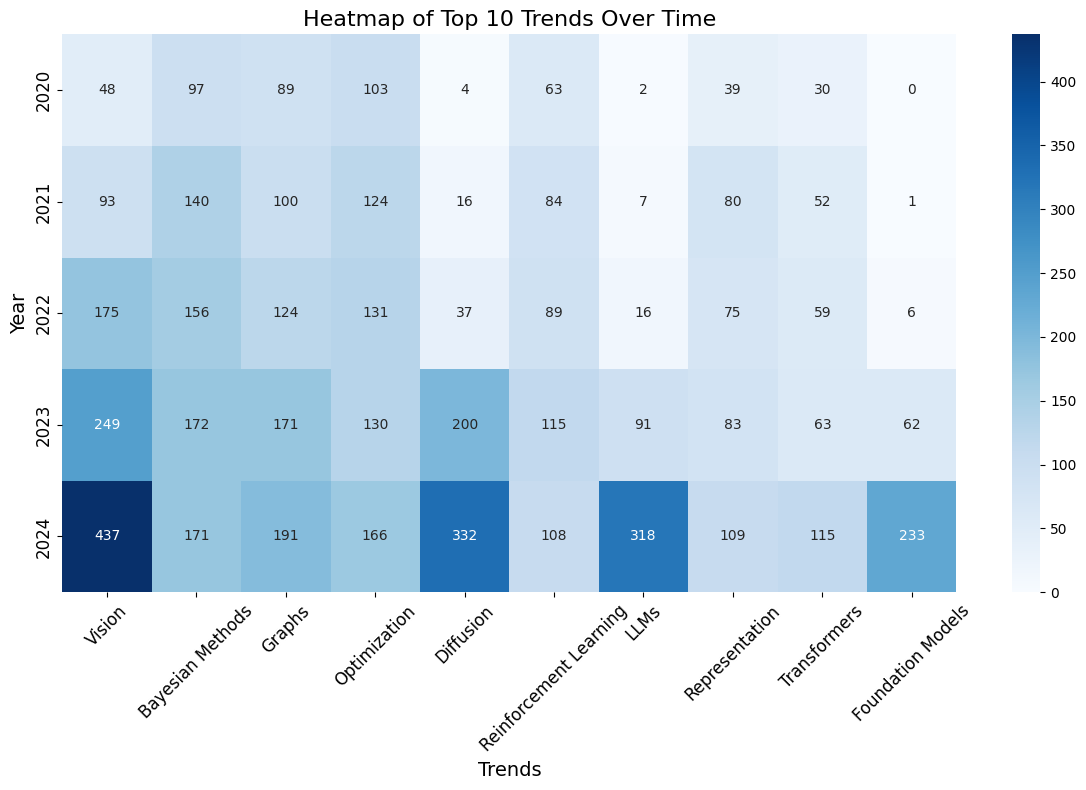

In [66]:
plot_heatmap_trends(ontology_frequencies_per_year, top_n=10)

### Normalized oncological heatmap trends

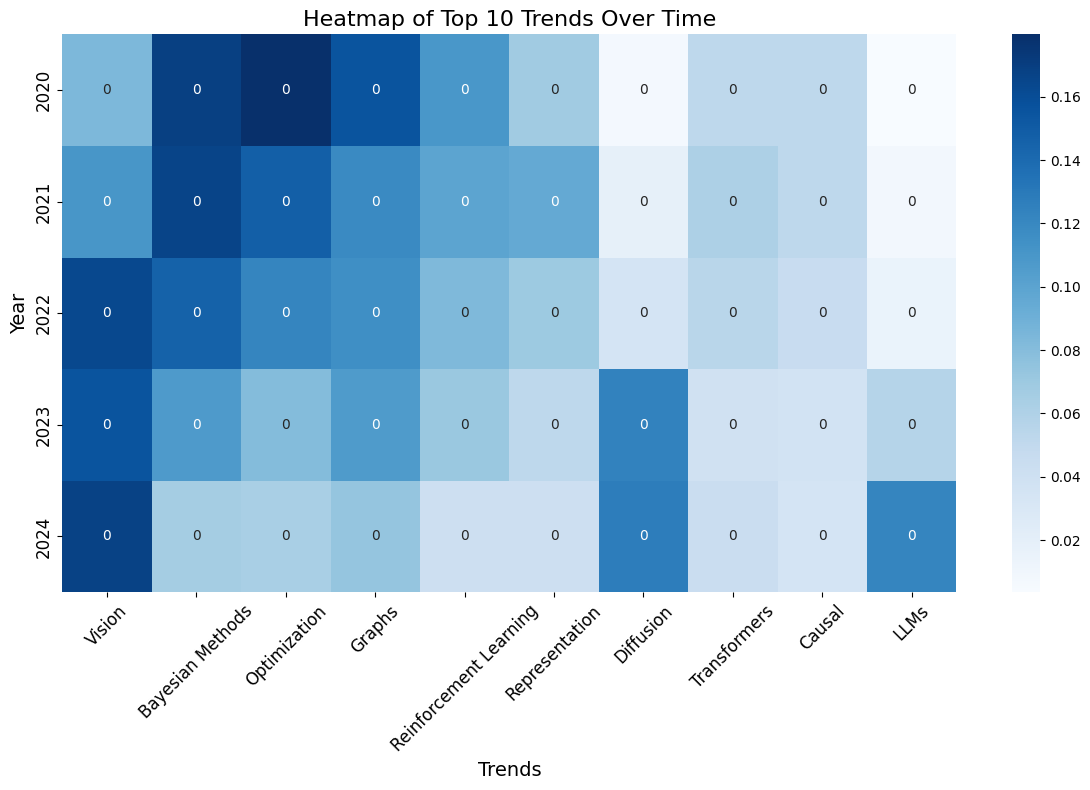

In [67]:
plot_heatmap_trends(ontology_df_normalized, top_n=10)

### Ontological small multiples trends

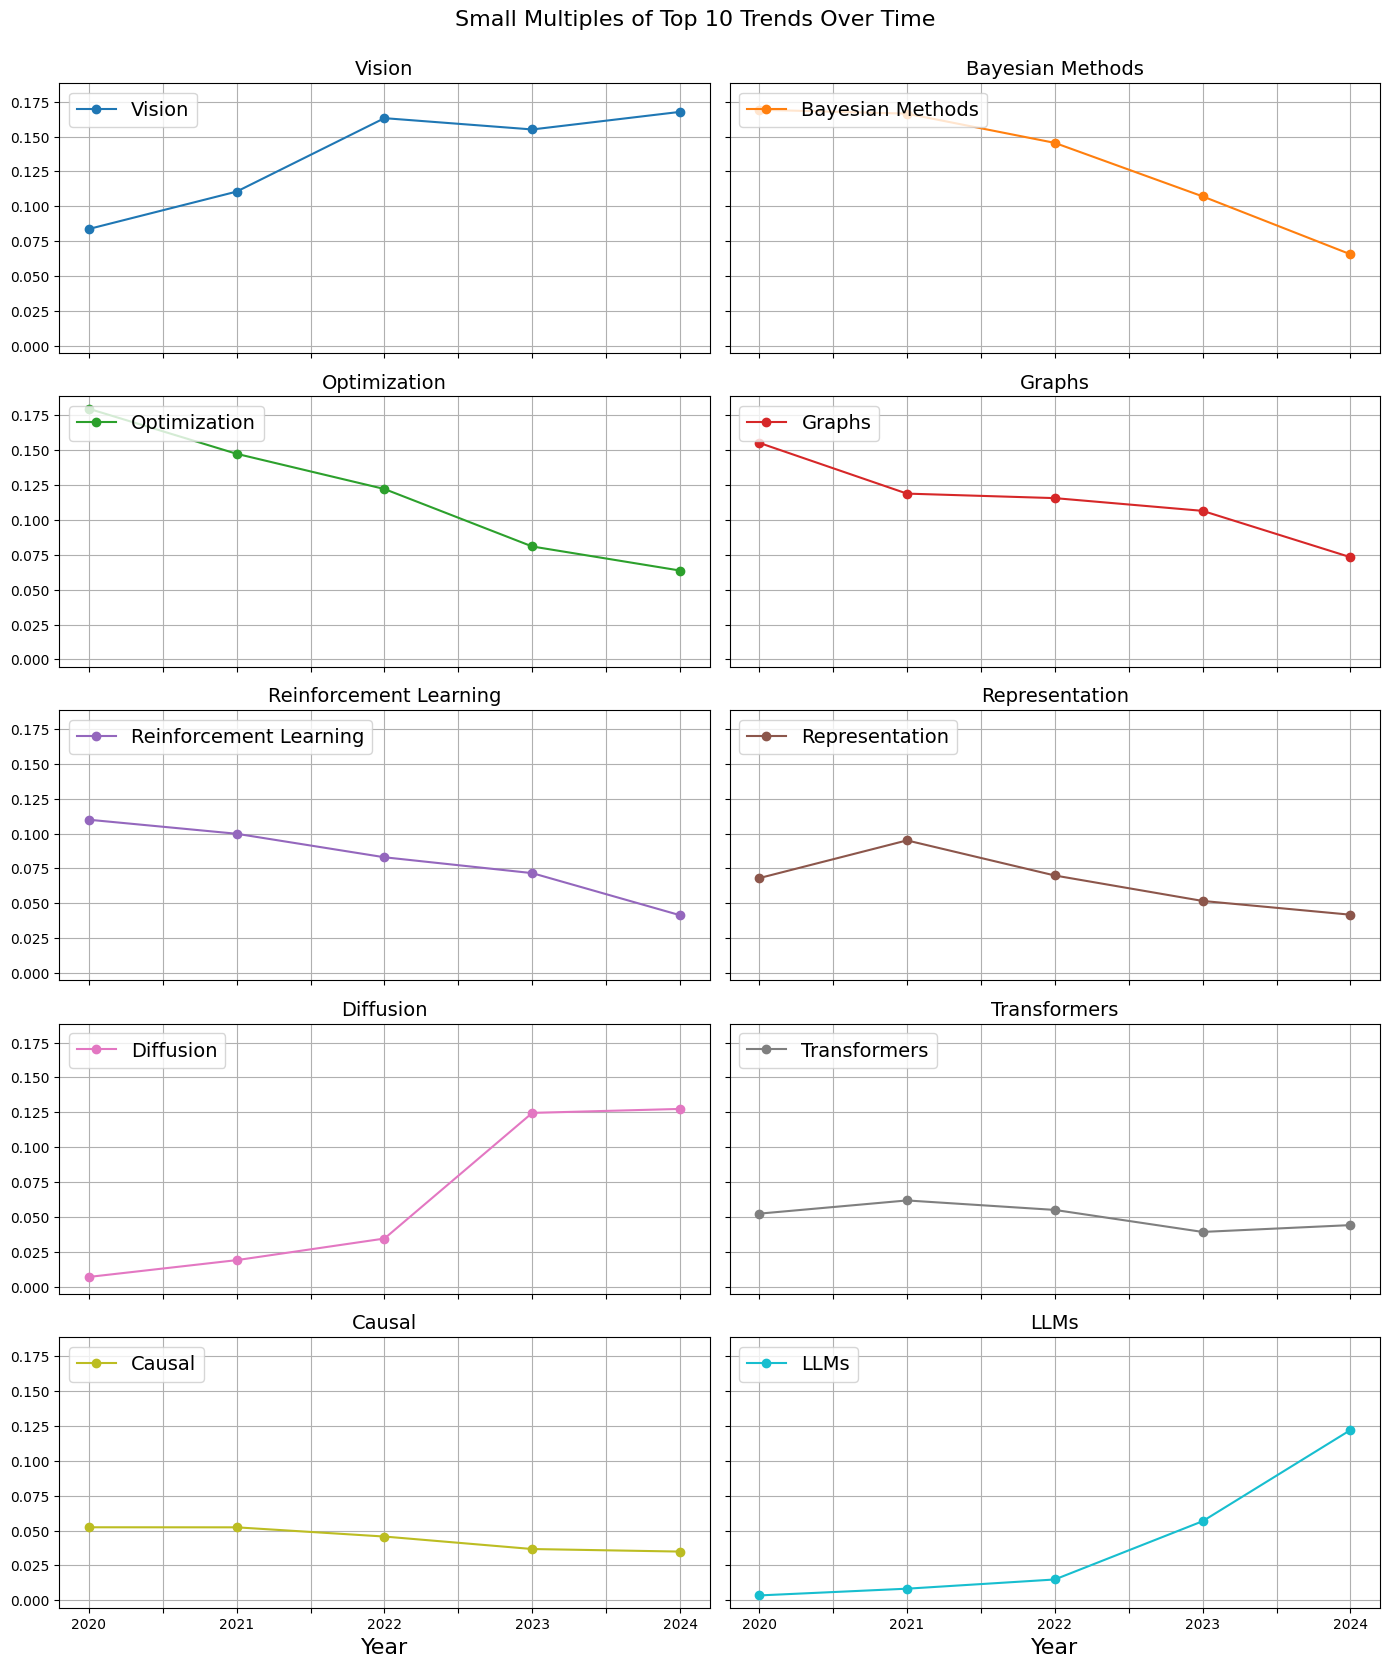

In [68]:
plot_small_multiples_trends(ontology_df_normalized, top_n=10)

# Save Report

In [73]:
import os

# Create a directory to save the figures
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# Function to save word clouds
def save_wordclouds_from_word_frequencies(frequencies: Dict[str, Counter], output_dir: str) -> None:
    for year, freqs in frequencies.items():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freqs)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"NeurIPS {year} Word Cloud", fontsize=16)
        plt.savefig(os.path.join(output_dir, f"wordcloud_{year}.png"))
        plt.close()

# Function to save bar plots
def save_top_topics(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    for year, frequencies in word_frequencies_per_year.items():
        df = pd.DataFrame(frequencies.items(), columns=["Topic", "Frequency"])
        top_topics = df.sort_values(by="Frequency", ascending=False).head(top_n)
        plt.figure(figsize=(10, 6))
        plt.bar(top_topics["Topic"], top_topics["Frequency"], color="skyblue")
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.title(f"Top {top_n} Topics in NeurIPS {year}", fontsize=16)
        plt.xlabel("Topic", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"top_topics_{year}.png"))
        plt.close()

# Function to save trend changes
def save_trend_changes(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    plt.figure(figsize=(12, 8))
    for trend in top_trends:
        plt.plot(trends_df.index, trends_df[trend], marker="o", label=trend)
    plt.title(f"Top {top_n} Trends Over the Past Years", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(trends_df.index, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title="Trends", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"trend_changes.png"))
    plt.close()

# Function to save stacked area trends
def save_stacked_area_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    trends_df.plot.area(figsize=(12, 8), alpha=0.7)
    plt.title(f"Stacked Area Plot of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title="Trends", fontsize=12, loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"stacked_area_trends.png"))
    plt.close()

# Function to save heatmap trends
def save_heatmap_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    plt.figure(figsize=(12, 8))
    sns.heatmap(trends_df, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title(f"Heatmap of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Trends", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"heatmap_trends.png"))
    plt.close()

# Function to save bubble trends
def save_bubble_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    trends_df = trends_df.reset_index().melt(id_vars="index", var_name="Trend", value_name="Frequency")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=trends_df,
        x="index",
        y="Trend",
        size="Frequency",
        sizes=(50, 500),
        hue="Trend",
        palette="tab10",
        legend=False
    )
    plt.title(f"Bubble Chart of Top {top_n} Trends Over Time", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Trends", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"bubble_trends.png"))
    plt.close()

# Function to save small multiples trends
def save_small_multiples_trends(word_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    trends_df = pd.DataFrame(word_frequencies_per_year).fillna(0)
    top_trends = trends_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    trends_df = trends_df.loc[top_trends].transpose()
    n_rows = (top_n + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    color_palette = plt.cm.tab10.colors
    num_colors = len(color_palette)
    for idx, (ax, trend) in enumerate(zip(axes, top_trends)):
        color = color_palette[idx % num_colors]
        trends_df[trend].plot(ax=ax, marker="o", color=color, legend=False)
        ax.set_title(trend, fontsize=14)
        ax.legend([trend], loc="upper left", fontsize=14)
        ax.grid(True)
        if idx >= len(top_trends):
            ax.axis("off")
    for ax in axes[-2:]:
        ax.set_xlabel("Year", fontsize=16)
    fig.suptitle(f"Small Multiples of Top {top_n} Trends Over Time", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(output_dir, f"small_multiples_trends.png"))
    plt.close()

# Save all figures
save_wordclouds_from_word_frequencies(word_frequencies_per_year, output_dir)
save_top_topics(word_frequencies_per_year, 10, output_dir)
save_trend_changes(word_frequencies_per_year, 10, output_dir)
save_stacked_area_trends(word_frequencies_per_year, 10, output_dir)
save_heatmap_trends(word_frequencies_per_year, 10, output_dir)
save_bubble_trends(word_frequencies_per_year, 10, output_dir)
save_small_multiples_trends(word_frequencies_per_year, 10, output_dir)


In [74]:
# Function to save ontology-based bar plots
def save_ontology_bar_plots(ontology_frequencies_per_year: Dict[str, Counter], top_n: int, output_dir: str) -> None:
    for year, frequencies in ontology_frequencies_per_year.items():
        df = pd.DataFrame(frequencies.items(), columns=["Category", "Frequency"])
        top_categories = df.sort_values(by="Frequency", ascending=False).head(top_n)
        plt.figure(figsize=(10, 6))
        plt.bar(top_categories["Category"], top_categories["Frequency"], color="skyblue")
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.title(f"Top {top_n} Ontology Categories in NeurIPS {year}", fontsize=16)
        plt.xlabel("Category", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"ontology_bar_plot_{year}.png"))
        plt.close()

# Save ontology-based bar plots
save_ontology_bar_plots(ontology_frequencies_per_year, 10, output_dir)

In [75]:
# Function to save ontology-based trends
def save_ontology_analysis(ontology_df: pd.DataFrame, output_dir: str, normalized: bool = False, top_n: int = 10) -> None:
    data_to_plot = ontology_df
    if normalized:
        data_to_plot = ontology_df.div(ontology_df.sum(axis=0), axis=1)
    
    top_categories = data_to_plot.sum(axis=1).sort_values(ascending=False).head(top_n).index
    data_to_plot = data_to_plot.loc[top_categories]

    plt.figure(figsize=(12, 8))
    for category in top_categories:
        plt.plot(
            data_to_plot.columns, 
            data_to_plot.loc[category], 
            marker='o', 
            label=category
        )
    plt.title(f"Ontology-Based Trends ({'Normalized' if normalized else 'Raw'})", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Frequency" if not normalized else "Proportion", fontsize=14)
    plt.legend(title="Categories", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    filename = f"ontology_trends_{'normalized' if normalized else 'raw'}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

# Function to save ontology-based heatmap trends
def save_ontology_heatmap_trends(ontology_df: pd.DataFrame, output_dir: str, top_n: int = 10) -> None:
    top_categories = ontology_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
    data_to_plot = ontology_df.loc[top_categories].transpose()

    plt.figure(figsize=(12, 8))
    sns.heatmap(data_to_plot, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title(f"Heatmap of Top {top_n} Ontology-Based Trends Over Time", fontsize=16)
    plt.xlabel("Trends", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"ontology_heatmap_trends.png"))
    plt.close()

# Save ontology-based trends
save_ontology_analysis(ontology_df, output_dir, normalized=False, top_n=10)
save_ontology_analysis(ontology_df_normalized, output_dir, normalized=True, top_n=10)
save_ontology_heatmap_trends(ontology_df, output_dir, top_n=10)
save_ontology_heatmap_trends(ontology_df_normalized, output_dir, top_n=10)

In [76]:
# Function to save ontology-based small multiples trends
def save_ontology_small_multiples_trends(ontology_df: pd.DataFrame, output_dir: str, top_n: int = 10, normalized: bool = False) -> None:
    data_to_plot = ontology_df
    if normalized:
        data_to_plot = ontology_df.div(ontology_df.sum(axis=0), axis=1)
    
    top_categories = data_to_plot.sum(axis=1).sort_values(ascending=False).head(top_n).index
    data_to_plot = data_to_plot.loc[top_categories]

    n_rows = (top_n + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    color_palette = plt.cm.tab10.colors
    num_colors = len(color_palette)
    for idx, (ax, category) in enumerate(zip(axes, top_categories)):
        color = color_palette[idx % num_colors]
        data_to_plot.loc[category].plot(ax=ax, marker="o", color=color, legend=False)
        ax.set_title(category, fontsize=14)
        ax.legend([category], loc="upper left", fontsize=14)
        ax.grid(True)
        if idx >= len(top_categories):
            ax.axis("off")
    for ax in axes[-2:]:
        ax.set_xlabel("Year", fontsize=16)
    fig.suptitle(f"Small Multiples of Top {top_n} {'Normalized ' if normalized else ''}Ontology Trends Over Time", fontsize=16, y=0.95)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f"ontology_small_multiples_trends_{'normalized' if normalized else 'raw'}.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.close()

# Save ontology-based small multiples trends
save_ontology_small_multiples_trends(ontology_df, output_dir, top_n=10, normalized=True)